In [1]:
#  read test.json
import json

import pandas as pd
import numpy as np

# train_file.json open
with open('train_file.json') as f:
    data = json.load(f)
#  convert json to pandas dataframe
train = pd.DataFrame(data)

# val_file.json open
with open('val_file.json') as f:
    data = json.load(f)

#  convert json to pandas dataframe
val = pd.DataFrame(data)

In [16]:
# concat train and val
df = pd.concat([train, val])

unique_speakers = set()
for i in range(len(df)):
    
    for sp in (df.iloc[i]['speakers']):
        unique_speakers.add(sp)

print(unique_speakers)
speaker_to_ix = {sp: i for i, sp in enumerate(unique_speakers)}

unique_emotions = set()
for j in range(len(df)):
    for sp in df.iloc[j]['emotions']:
        unique_emotions.add(sp)

print(unique_emotions)
emotion_to_ix = {sp: i for i, sp in enumerate(unique_emotions)}

print(speaker_to_ix)
print(emotion_to_ix)

# create word to index
word_to_ix = {}
for i in range(len(df)):
    for sent in df.iloc[i]['utterances']:
        for word in sent.split():   
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)

print(word_to_ix)

    

{'The Grip', 'Joshua', 'Kim', 'Stranger', 'Ticket Counter Attendant', 'Jim', 'The Guys', 'Monica', 'Megan', 'Joey', 'Mona', 'Kristin', 'Paleontologist', 'A Student', 'Phoebe and Rachel', 'Bobby', 'Nurse', 'Alice', 'The Acting Teacher', 'Earl', 'The Head Librarian', 'The Potential Roommate', 'Raymond', 'Jane', 'Dana', 'Woman On Train', 'Both', 'Voice', 'Estelle', 'Peter', 'The Smoking Woman', 'Mr. Heckles', 'Casey', 'Dr. Zane', 'Fake Monica', 'Russell', 'Danny', 'Mr. Tribbiani', 'The Lurker', 'The Instructor', 'Barry', 'Sarah', 'Janice', 'Mrs. Tedlock', 'Flight Attendant', 'Dr. Long', 'Mr. Zelner', 'Aunt Lillian', 'Tom', 'Dr. Leedbetter', 'Ronni', 'Hotel Clerk', 'Chloe', 'Jade', 'Dr. Drake Remoray', 'Young Ethan', 'Kiki', 'Nancy', 'Duncan', 'Another Scientist', 'Drunken Gambler', 'Hoshi', 'Jen', 'Paul', 'Policeman', 'Frank', 'Doctor', 'The Hot Girl', 'Another Tour Guide', 'Dr. Miller', 'Mrs. Burgin', 'Customer', "Maitre d'", 'Mark', 'Shelley', 'All', 'Nurse #2', 'Elizabeth', 'The Cookin

In [3]:
# print(emotions)

# ṭake 1% of the total data for training 
# df = train.sample(frac=0.01, random_state=1)
df = train.sample(frac=0.9, random_state=1)

#  check if the number of utterances and triggers are same
# check_length(df)

# reset indexes 
df.reset_index(drop=True, inplace=True)


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Example data setup
utterances=df['utterances']

triggers=df['triggers']
speakers=df['speakers']
emotions=df['emotions']






# Flatten the utterances for proper sequence processing
utterances_flat = [item for sublist in utterances for item in sublist]
triggers_flat = [item for sublist in triggers for item in sublist]
speaker_flat = [item for sublist in speakers for item in sublist]
emotion_flat = [item for sublist in emotions for item in sublist]


# encode speakers and emotions
speaker_flat = [speaker_to_ix[sp] for sp in speaker_flat]
emotion_flat = [emotion_to_ix[sp] for sp in emotion_flat]


# Parameters
max_vocab_size = 10000
max_sequence_length = 50
embedding_dim = 50
lstm_dim = 128

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(utterances_flat)
X_seq = pad_sequences(tokenizer.texts_to_sequences(utterances_flat), maxlen=max_sequence_length)

# Triggers as numpy array
y = np.array(triggers_flat)

# convert X_seq and y to tensor arrays
X_seq = tf.convert_to_tensor(X_seq)
# replace None with zeros
y = [0 if i is None else i for i in y]
y=[int(i) for i in y ]
y = tf.convert_to_tensor(y)


# Assuming 'speaker_to_ix' and 'emotion_to_ix' have already been defined and used as shown in your previous code
num_speakers = len(speaker_to_ix)  # Update this with the actual count
num_emotions = len(emotion_to_ix)  # Update this with the actual count

# Additional Parameters
speaker_embedding_dim = 20
emotion_embedding_dim = 20

# Inputs
input_utterances = Input(shape=(max_sequence_length,), dtype='int32')
input_speakers = Input(shape=(1,), dtype='int32')
input_emotions = Input(shape=(1,), dtype='int32')

# Embeddings
embedding_layer = Embedding(max_vocab_size, embedding_dim)(input_utterances)
speaker_embedding = Embedding(num_speakers, speaker_embedding_dim)(input_speakers)
emotion_embedding = Embedding(num_emotions, emotion_embedding_dim)(input_emotions)

# Flatten speaker and emotion embeddings (since they're just single vectors)
speaker_embedding = Flatten()(speaker_embedding)
emotion_embedding = Flatten()(emotion_embedding)

# LSTM layer for the utterance embeddings
lstm_out = LSTM(lstm_dim, return_sequences=False)(embedding_layer)

# Concatenate LSTM output with speaker and emotion embeddings
concatenated = Concatenate()([lstm_out, speaker_embedding, emotion_embedding])


# Output layer
output_trigger = Dense(1, activation='sigmoid')(concatenated)

# Build the model
model = Model(inputs=[input_utterances, input_speakers, input_emotions], outputs=output_trigger)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert speaker and emotion arrays to tensors
X_speaker = tf.convert_to_tensor(speaker_flat, dtype=tf.int32)
X_emotion = tf.convert_to_tensor(emotion_flat, dtype=tf.int32)

# Train the model
model.fit([X_seq, X_speaker, X_emotion], y, epochs=10, batch_size=32, validation_split=0.1)





Epoch 1/10
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 61s 32ms/step - accuracy: 0.8411 - loss: 0.4316 - val_accuracy: 0.8492 - val_loss: 0.4022
Epoch 2/10
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - accuracy: 0.8464 - loss: 0.3869 - val_accuracy: 0.8492 - val_loss: 0.3960
Epoch 3/10
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.8511 - loss: 0.3676 - val_accuracy: 0.8456 - val_loss: 0.3960
Epoch 4/10
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - accuracy: 0.8577 - loss: 0.3463 - val_accuracy: 0.8486 - val_loss: 0.3913
Epoch 5/10
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - accuracy: 0.8581 - loss: 0.3428 - val_accuracy: 0.8483 - val_loss: 0.3932
Epoch 6/10
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - accuracy: 0.8583 - loss: 0.3350 - val_accuracy: 0.8524 - val_loss: 0.3867
Epoch 7/10
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - accuracy: 0.8637 - loss: 0.3277 - val_accuracy: 0.8531 - val_loss: 0.3950
Epoch 8/10
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - accuracy: 0.8641 -

In [24]:

# Predict triggers and convert to binary
predicted_triggers = model.predict([X_seq, X_speaker, X_emotion])
predicted_triggers = [1 if i > 0.4 else 0 for i in predicted_triggers]
predicted_triggers = np.array(predicted_triggers)

# Calculate accuracy
accuracy = np.mean(predicted_triggers == y)
print(f'Accuracy: {accuracy}')

# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, predicted_triggers)
print(cm)

2071/2071 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step
Accuracy: 0.8665056603773585
[[53516  2284]
 [ 6560  3890]]


In [38]:
# test the model on validation dataset
val_utterances=val['utterances']
val_triggers=val['triggers']
val_speakers=val['speakers']
val_emotions=val['emotions']

val_utterances_flat = [item for sublist in val_utterances for item in sublist]
val_triggers_flat = [item for sublist in val_triggers for item in sublist]
val_speaker_flat = [item for sublist in val_speakers for item in sublist]
val_emotion_flat = [item for sublist in val_emotions for item in sublist]

val_speaker_flat = [speaker_to_ix[sp] for sp in val_speaker_flat]
val_emotion_flat = [emotion_to_ix[sp] for sp in val_emotion_flat]

val_X_seq = pad_sequences(tokenizer.texts_to_sequences(val_utterances_flat), maxlen=max_sequence_length)
# val_y = np.array(val_triggers_flat)

val_X_seq = tf.convert_to_tensor(val_X_seq)
# val_y = [0 if i is None else i for i in val_y]
# val_y=[int(i) for i in val_y ]
# val_y = tf.convert_to_tensor(val_y)

val_X_speaker = tf.convert_to_tensor(val_speaker_flat, dtype=tf.int32)
val_X_emotion = tf.convert_to_tensor(val_emotion_flat, dtype=tf.int32)

# Predict triggers and convert to binary
predicted_triggers = model.predict([val_X_seq, val_X_speaker, val_X_emotion])
predicted_triggers = [1 if i > 0.4 else 0 for i in predicted_triggers]
predicted_triggers = np.array(predicted_triggers)



228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step


In [31]:
#  validation classificaiton report
accuracy = np.mean(predicted_triggers == val_triggers_flat)
print(f'Accuracy: {accuracy}')

from sklearn.metrics import classification_report
val_triggers_flat = [0 if i is None else i for i in val_triggers_flat]
print(classification_report(val_triggers_flat, predicted_triggers))


Accuracy: 0.8438228438228438
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      6186
         1.0       0.47      0.27      0.35      1107

    accuracy                           0.84      7293
   macro avg       0.68      0.61      0.63      7293
weighted avg       0.82      0.84      0.83      7293



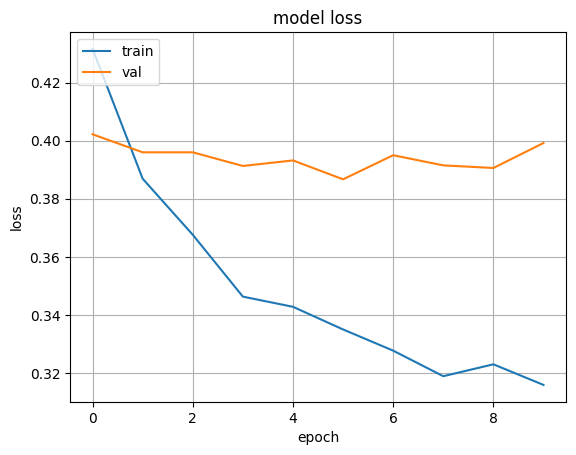

In [35]:
# Epoch 1/10
# 1864/1864 ━━━━━━━━━━━━━━━━━━━━ 61s 32ms/step - accuracy: 0.8411 - loss: 0.4316 - val_accuracy: 0.8492 - val_loss: 0.4022
# Epoch 2/10
# 1864/1864 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - accuracy: 0.8464 - loss: 0.3869 - val_accuracy: 0.8492 - val_loss: 0.3960
# Epoch 3/10
# 1864/1864 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.8511 - loss: 0.3676 - val_accuracy: 0.8456 - val_loss: 0.3960
# Epoch 4/10
# 1864/1864 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - accuracy: 0.8577 - loss: 0.3463 - val_accuracy: 0.8486 - val_loss: 0.3913
# Epoch 5/10
# 1864/1864 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - accuracy: 0.8581 - loss: 0.3428 - val_accuracy: 0.8483 - val_loss: 0.3932
# Epoch 6/10
# 1864/1864 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - accuracy: 0.8583 - loss: 0.3350 - val_accuracy: 0.8524 - val_loss: 0.3867
# Epoch 7/10
# 1864/1864 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - accuracy: 0.8637 - loss: 0.3277 - val_accuracy: 0.8531 - val_loss: 0.3950
# Epoch 8/10
# 1864/1864 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - accuracy: 0.8641 - loss: 0.3189 - val_accuracy: 0.8512 - val_loss: 0.3915
# Epoch 9/10
# 1864/1864 ━━━━━━━━━━━━━━━━━━━━ 67s 36ms/step - accuracy: 0.8640 - loss: 0.3230 - val_accuracy: 0.8540 - val_loss: 0.3906
# Epoch 10/10
# 1864/1864 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.8659 - loss: 0.3159 - val_accuracy: 0.8542 - val_loss: 0.3992a

# plot the graph for training of model  train loss and val loss per epoch
import matplotlib.pyplot as plt
train_loss = [0.4316, 0.3869, 0.3676, 0.3463, 0.3428, 0.3350, 0.3277, 0.3189, 0.3230, 0.3159]
val_loss = [0.4022, 0.3960, 0.3960, 0.3913, 0.3932, 0.3867, 0.3950, 0.3915, 0.3906, 0.3992]
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# show grid 
plt.grid()
plt.show()


In [36]:
#  save the model checkpoint
model.save('model.h5')


In [37]:
#  load the model
from tensorflow.keras.models import load_model
model = load_model('model.h5')
